# Benchmark for Jensen Shannon

----

## Data

> **Goal:** First we will <span style="color:cyan">**generate random data**</span> from two distributions. A "Category" column which will have Drift, and another "Number" column which will not have a difference in distribution

In [1]:
from generate_data import RandomDataGenerator
import random

random.seed(42)
rdg = RandomDataGenerator()

data_range_min = 100
data_range_max = 1000000
range_col_min  = 2
range_col_max  = 20

# Obtenir la liste des nombres de données et de catégories
dfs = rdg.number_data(data_range_min, data_range_max, range_col_min, range_col_max)

print(f"Nombre de dataframes générés : {len(dfs)}")


Nombre de dataframes générés : 15


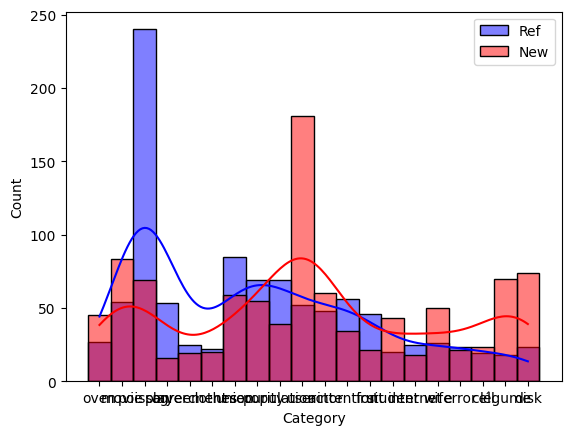

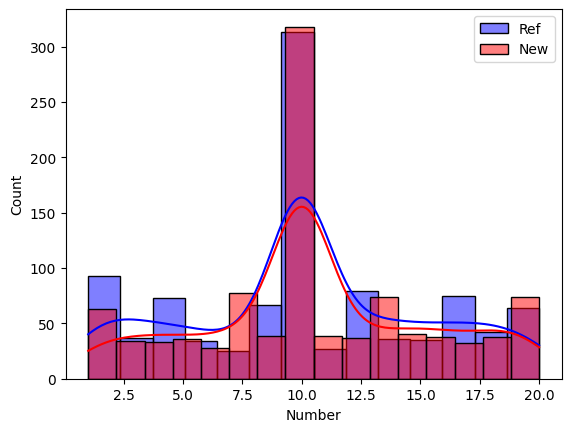

In [2]:
from charts import Graphics

charts = Graphics()

exemple_ref = dfs[5]['Data'][0]
exemple_new = dfs[5]['Data'][1]

charts.plot_hist(exemple_ref, exemple_new, 'Category')
charts.plot_hist(exemple_ref, exemple_new, 'Number')

## Drift

> **Goal:** <span style="color:cyan">**Detect a Drift**</span> on the distributions. But **only on the first column** and not the second

In [3]:
from detect_drift import DetectDrift

list_methods  = ["js", "wd", "ks"]
all_benchmark = []

for method in list_methods:
    detection   = DetectDrift(method)
    benchmark_detail, benchmark = detection.method_drift(dfs)
    all_benchmark.append({'Test': method, "Result": (benchmark_detail, benchmark)})

final_benchmark = detection.final_benchmark(all_benchmark)


In [4]:
final_benchmark

,Method,Correct_Ratio,Avg_Time
0,js,0.800,0.000067
1,wd,0.067,0.000129
2,ks,0.000,0.000067


## Analyse

> **Goal:** We display <span style="color:cyan">**the course of the js**</span> to see the disturbances

In [11]:
from analyse_drift import AnalyseDrift

analyser = AnalyseDrift("js")

splited_data_ref, splited_data_new = analyser.split_data(dfs)

js_time_cat_df, js_time_num_df     = analyser.method_timeline(splited_data_ref,splited_data_new)

Change detected at index 351, input value: (351, 0    0.359444
Name: 351, dtype: float64)
Change detected at index 1311, input value: (1311, 0    0.051329
Name: 1311, dtype: float64)


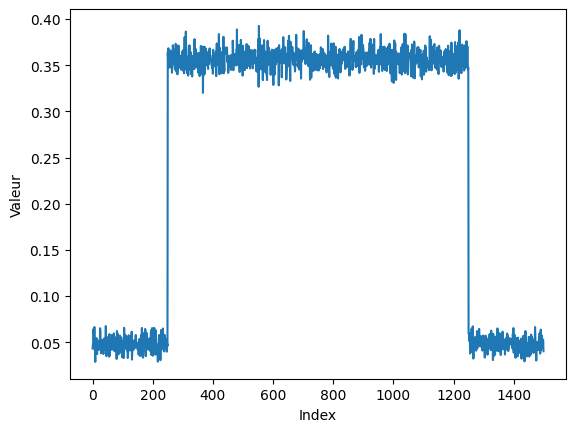

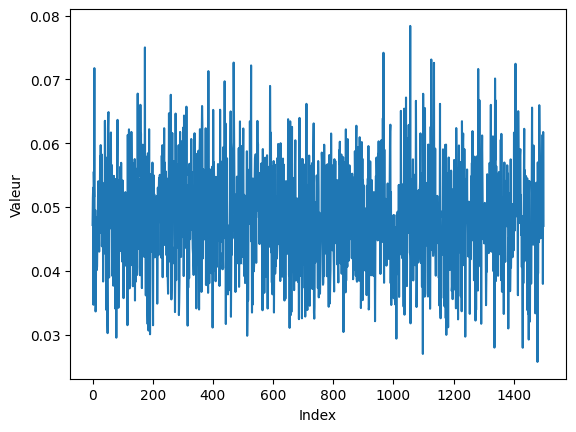

In [13]:
detection.adwin(js_time_cat_df)
charts.plot_graph(js_time_cat_df)
detection.adwin(js_time_num_df)
charts.plot_graph(js_time_num_df)

> **Goal:** We seek <span style="color:cyan">**the average of the value of the method**</span> to define it by default

In [9]:
moyenne_cat, moyenne_num = analyser.average_method(dfs)
print(moyenne_cat, moyenne_num)

0.06885368730173061 0.06815397224497668
